In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 352830705 (Pair B)

- the one with ~3d period (low SNR)
- Discussion at
  - https://www.zooniverse.org/projects/vbkostov/eclipsing-binary-patrol/talk/6324/3531040?comment=5800860&page=1


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 352830705

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_B_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_B_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: use_sap_flux(lc).normalize()
)
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 10 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 15 2019    QLP    1800   352830705      0.0         N/A
  1 TESS Sector 16 2019    QLP    1800   352830705      0.0         N/A
  2 TESS Sector 17 2019    QLP    1800   352830705      0.0         N/A
  3 TESS Sector 24 2020    QLP    1800   352830705      0.0         N/A
  4 TESS Sector 56 2022    QLP     200   352830705      0.0         N/A
  5 TESS Sector 57 2022    QLP     200   352830705      0.0         N/A
  6 TESS Sector 58 2022    QLP     200   352830705      0.0         N/A
  7 TESS Sector 76 2024    QLP     200   352830705      0.0         N/A
  8 TESS Sector 77 2024    QLP     200   352830705      0.0         N/A
  9 TESS Sector 78 2024    QLP     200   352830705      0.0         N/A

64434

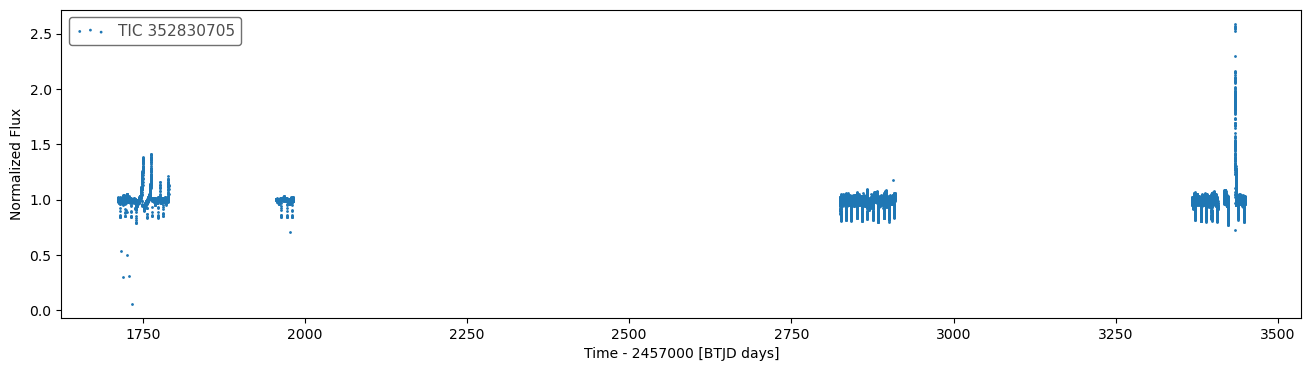

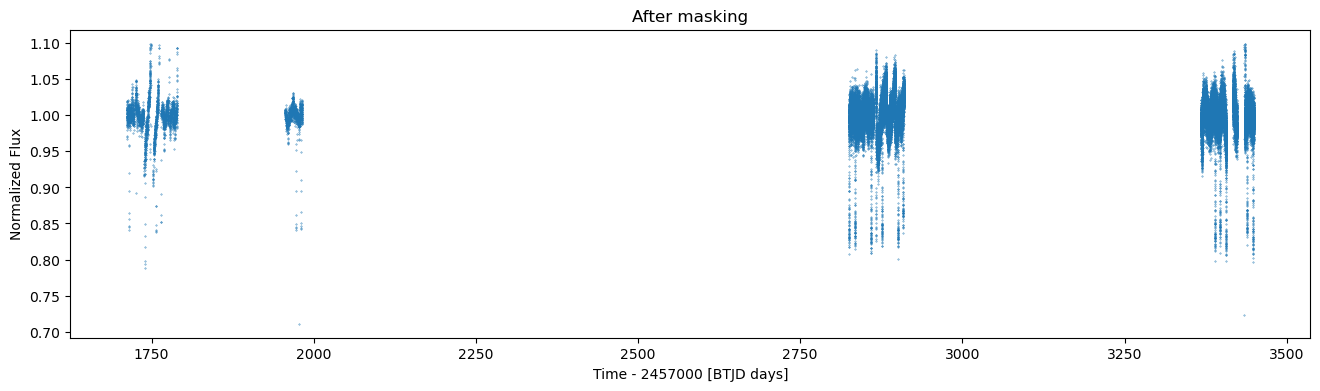

In [37]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=(figsize[0] * 2, figsize[1]))
search_result.scatter(ax = ax)

# mask out dips that are blended / or close to unrelated dips
mask = time < 0
mask = mask | ( time > 1719) & (time < 1720)
mask = mask | ( time > 1722.5) & (time < 1723.5)
mask = mask | ( time > 1731.0) & (time < 1732.0)
mask = mask | ( time > 1752.0) & (time < 1753.0)
mask = mask | ( time > 1760.5) & (time < 1761.5)
mask = mask | ( time > 1772.5) & (time < 1773.5)
mask = mask | ( time > 1781) & (time < 1782)
mask = mask | ( time > 1963.5) & (time < 1964.5)
mask = mask | ( time > 1975.5) & (time < 1976.5)
mask = mask | ( time > 2829.5) & (time < 2830.5)
mask = mask | ( time > 2842.0) & (time < 2843.0)
mask = mask | ( time > 2850.5) & (time < 2851.5)
mask = mask | ( time > 2862.5) & (time < 2863.5)
mask = mask | ( time > 2871.0) & (time < 2872.0)
mask = mask | ( time > 2883.3) & (time < 2884.3)
mask = mask | ( time > 2891.5) & (time < 2892.5)
mask = mask | ( time > 3372.5) & (time < 3373.5)
mask = mask | ( time > 3381.0) & (time < 3382.0)
mask = mask | ( time > 3401.5) & (time < 3402.5)
mask = mask | ( time > 3422.0) & (time < 3423.0)
mask = mask | ( time > 3443.0) & (time < 3444.0)
mask = mask | (flux > 1.1)  # remove random spikes (probably associated with scattered light not removed from QLP)
mask = mask | (flux < 0.7)  # remove random outliers dips

# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.95 ) | # remove occasional lone outliers
#     # cadences where scattered light effect is prevalent
#     ( (time > 2718)   & (time < 2744) )
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=(figsize[0] * 2, figsize[1])).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

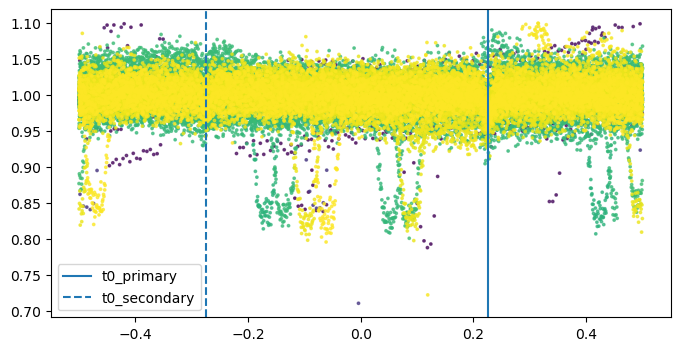

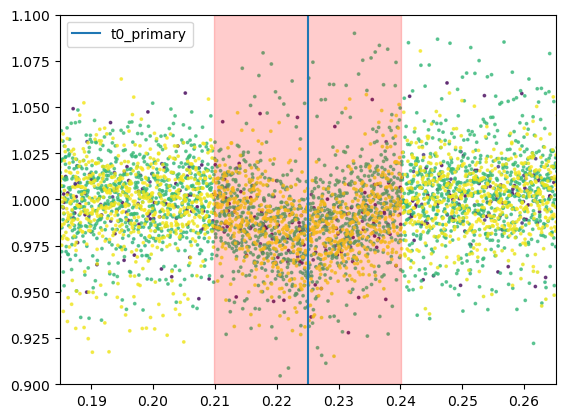

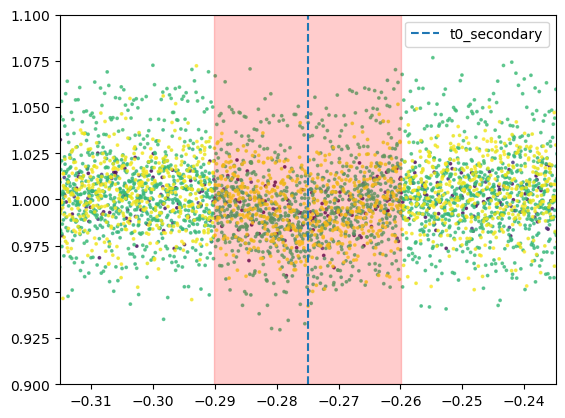

In [39]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# MCMC on df_primary: mean_p=3.444156974321003, std_p: 4.037167025215307e-06 ; t0=1712.658332451943, std_t0: 0.001414313156013865

# FILL-IN THE eclipse epoch / period,
period = 3.44417  # eybeball
period = 3.44416  # MCMC

t0_primary = 1767.76  # eyeball
t0_primary = 1712.66  # MCMC
t0_secondary = t0_primary + period / 2

duration_hr_primary = 2.5
duration_hr_secondary = 2.5

# ignore secondary for now
# t0_secondary = 1719.21
# duration_hr_secondary = 4.5

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
plt.ylim(0.9, 1.1);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    plt.ylim(0.9, 1.1);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [40]:
data["flux_original"] = data.flux

In [ ]:
# show data to visualize what's changed in each step below
data

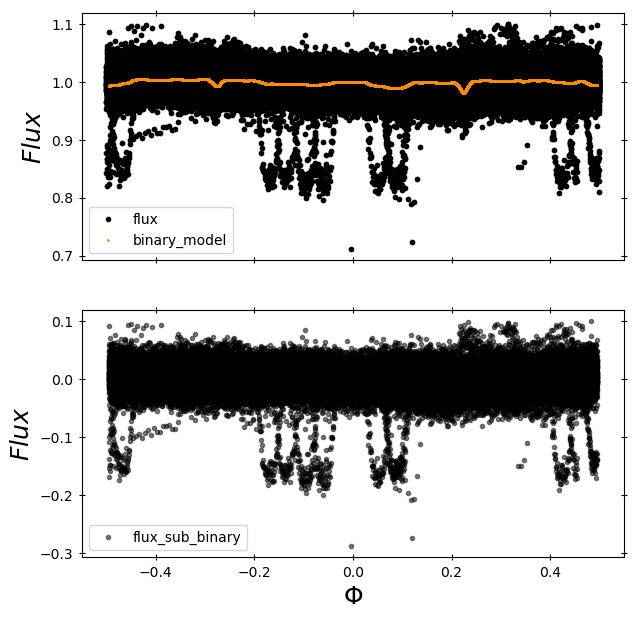

time      flux       err     phase  flux_original  \
0      1711.384817  1.007575  0.006586 -0.145245       1.007575   
1      1711.405651  1.006582  0.006586 -0.139196       1.006582   
2      1711.426485  1.007415  0.006586 -0.133147       1.007415   
3      1711.447319  1.006773  0.006586 -0.127098       1.006773   
4      1711.468153  1.019929  0.006586 -0.121049       1.019929   
...            ...       ...       ...       ...            ...   
58494  3449.497777  0.993219  0.014067 -0.490130       0.993219   
58495  3449.500092  1.006991  0.014067 -0.489458       1.006991   
58496  3449.502407  0.997731  0.014067 -0.488786       0.997731   
58497  3449.504722  1.003137  0.014067 -0.488114       1.003137   
58498  3449.507037  0.978592  0.014067 -0.487442       0.978592   

       flux_sub_binary  binary_model  
0             0.011410      0.996165  
1             0.010152      0.996430  
2             0.010731      0.996684  
3             0.009829      0.996945  
4             0.022969      0.996960  
...                ...           ...  
58494        -0.000615      0.993835  
58495         0.013087      0.993903  
58496         0.003760      0.993971  
58497         0.009097      0.994039  
58498        -0.015515      0.994106  

[58499 rows x 7 columns]

In [41]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 57873 901
reached the end
10 56362 901
reached the end
10 56187 901
reached the end
10 56154 901
reached the end
10 56144 901
reached the end


time      flux       err     phase  flux_original  \
0      1711.384817  1.007575  0.006586 -0.145245       1.007575   
1      1711.405651  1.006582  0.006586 -0.139196       1.006582   
2      1711.426485  1.007415  0.006586 -0.133147       1.007415   
3      1711.447319  1.006773  0.006586 -0.127098       1.006773   
4      1711.468153  1.019929  0.006586 -0.121049       1.019929   
...            ...       ...       ...       ...            ...   
58494  3449.497777  0.993219  0.014067 -0.490130       0.993219   
58495  3449.500092  1.006991  0.014067 -0.489458       1.006991   
58496  3449.502407  0.997731  0.014067 -0.488786       0.997731   
58497  3449.504722  1.003137  0.014067 -0.488114       1.003137   
58498  3449.507037  0.978592  0.014067 -0.487442       0.978592   

       flux_sub_binary  binary_model  flux_detrended  
0             0.011410      0.996165        0.995059  
1             0.010152      0.996430        0.994104  
2             0.010731      0.996684        0.994977  
3             0.009829      0.996945        0.994376  
4             0.022969      0.996960        1.007571  
...                ...           ...             ...  
58494        -0.000615      0.993835        0.991297  
58495         0.013087      0.993903        1.005077  
58496         0.003760      0.993971        0.995821  
58497         0.009097      0.994039        1.001231  
58498        -0.015515      0.994106        0.976691  

[58499 rows x 8 columns]

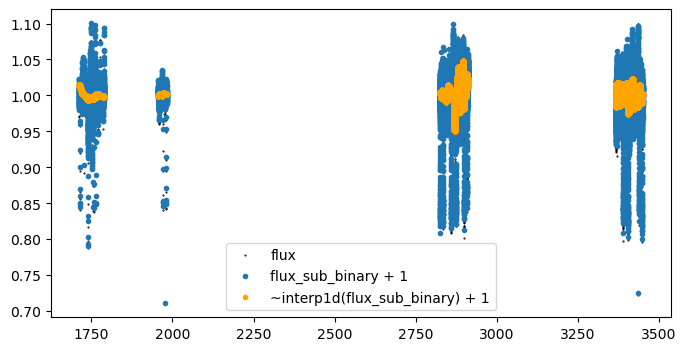

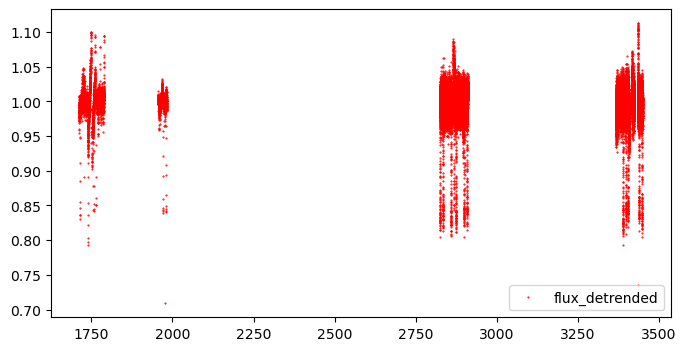

In [42]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

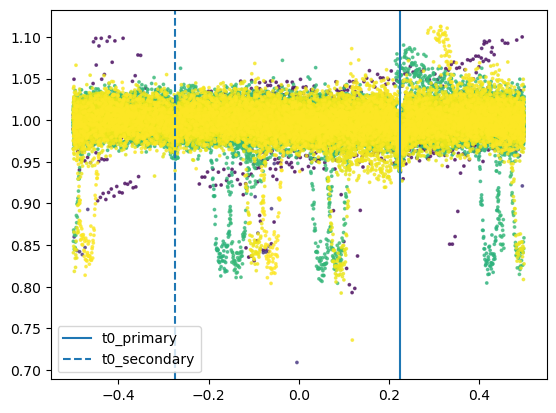

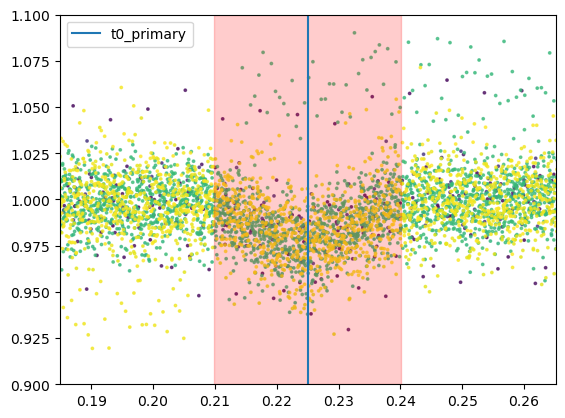

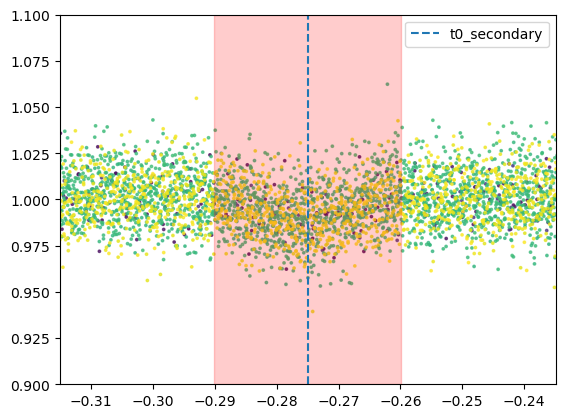

In [43]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
plt.ylim(0.9, 1.1);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    plt.ylim(0.9, 1.1);
    plt.show()

In [31]:
print("Use deterended flux")
data.flux = data.flux_detrended

Use deterended flux


<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [47]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.9 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.9 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
# start_vals = [1.0, -0.02, midpoint_p, 0.0065, 1.8]  # manual
start_vals = [1.001, -0.024, midpoint_p, 0.0094, 0.663]  # MCMC result much more V-shaped
# start_vals_s = [1.0, -0.014, midpoint_s, 0.005, 2.0]  # manual first cut
start_vals_s = [1.005, -0.014, midpoint_s, 0.009, 0.7]  # manul second cut, make it more V-shaped

# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1712.66 0.2250000000000073
window_width_p (phase): 0.027219989779801168
Secondary: 1714.38208 -0.27499999999999114
window_width_s (phase): 0.027219989779801168


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.001, -0.024, 1712.66, 0.0094, 0.663, 3.44416],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 2000/2000 [02:16<00:00, 14.63it/s]


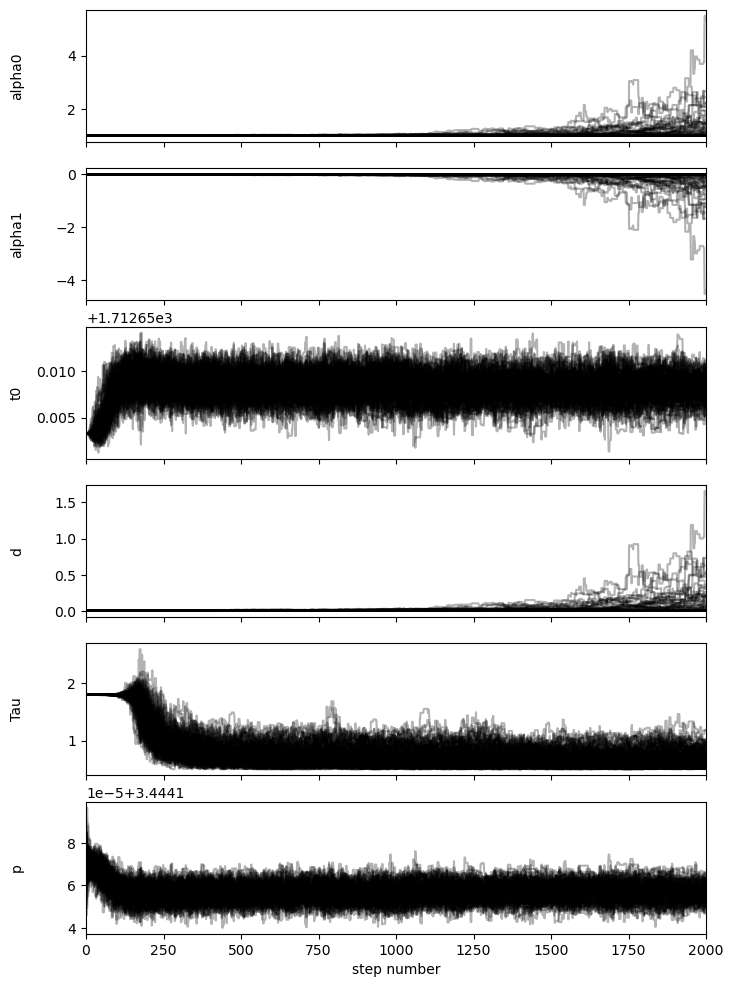

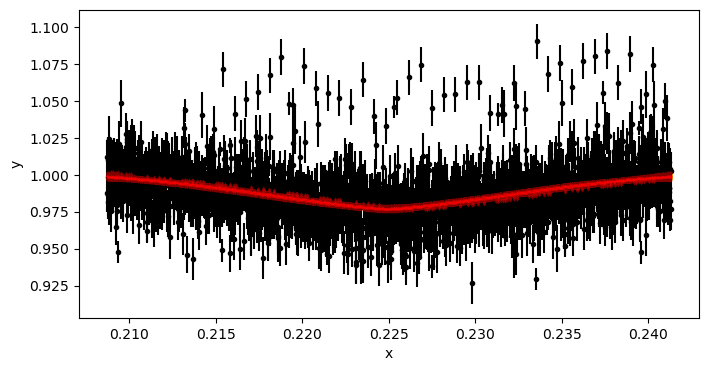

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0011338199252215, -0.024268776809656015, 1712.658332451943, 0.009401269102659135, 0.6622937059060647, 3.444156974321003
std_p: 4.037167025215307e-06 ; std_t0: 0.001414313156013865


In [34]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.02, 1712.65328, 0.0065, 1.8, 3.44417],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        # nruns=1000, discard=600,
        nruns=2000, discard=1000,
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 2000/2000 [01:35<00:00, 20.86it/s]


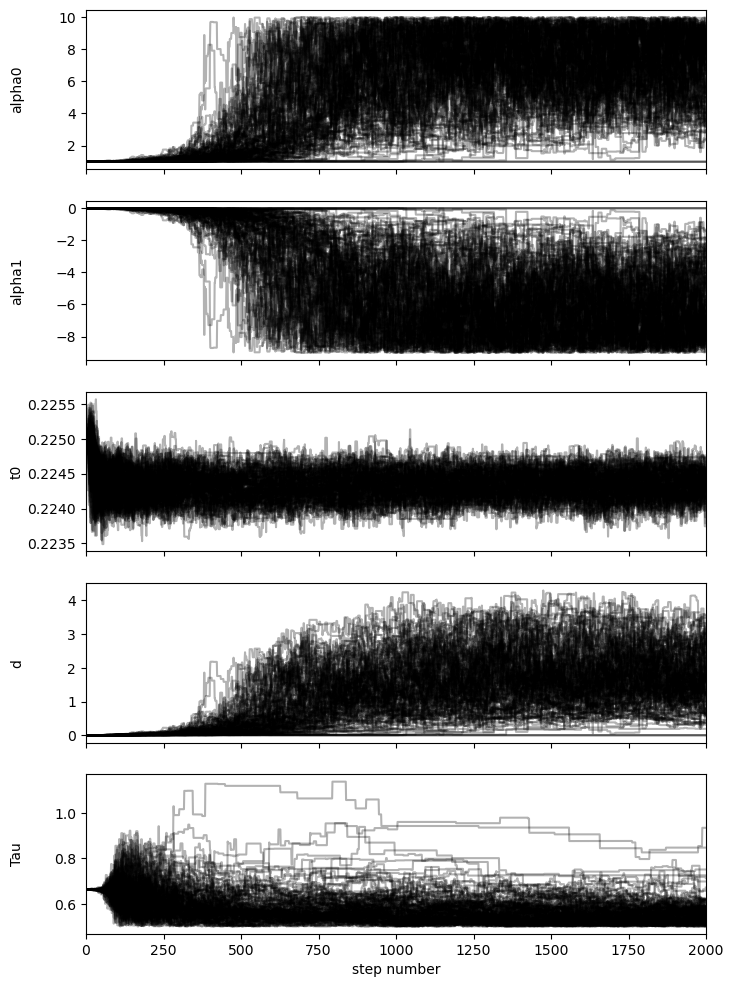

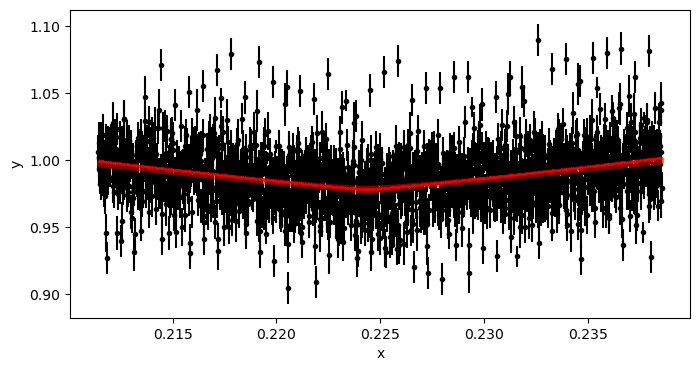

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 2000/2000 [01:32<00:00, 21.52it/s]


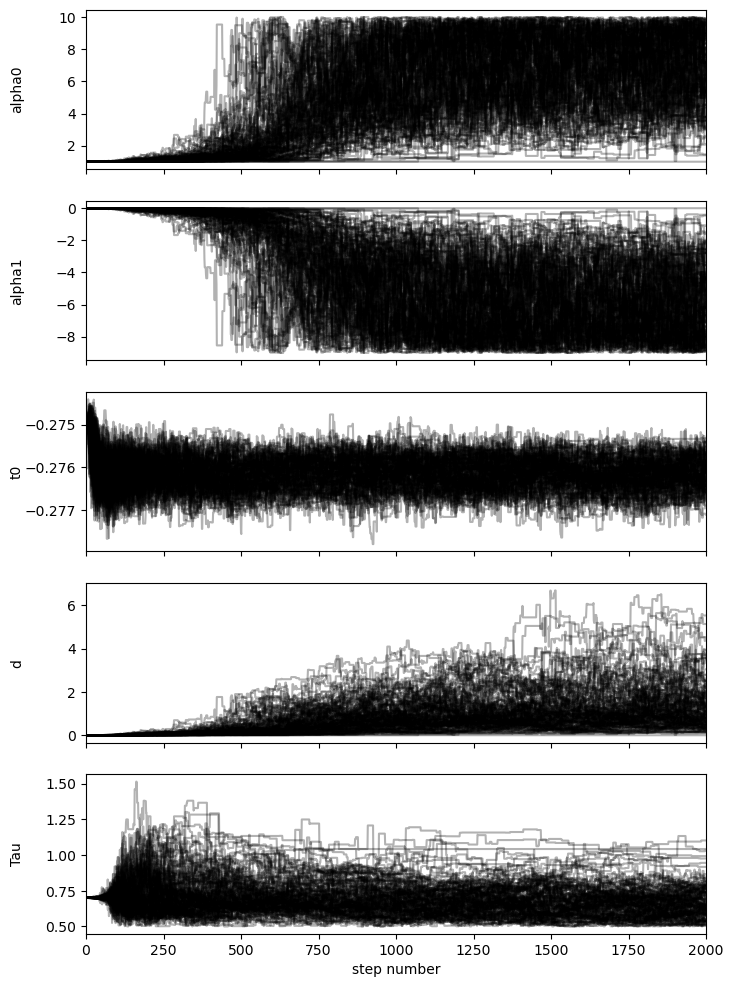

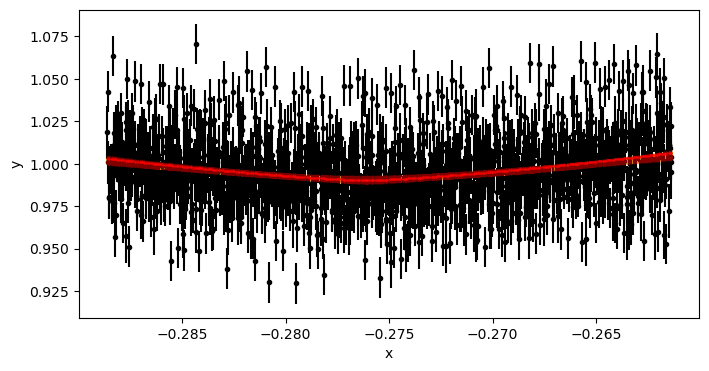

In [49]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=2000, discard=1000, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=2000, discard=1000, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data (window od duration * 0.9], nruns=2000
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 7.006149634502908, -6.028086328487624, 0.22434302238334453, 1.494662699379815, 0.5538180161966535
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 6.8169425009886915, -5.826747964120661, -0.2761378037506219, 0.8577276064348123, 0.6676934010181281

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [50]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 7.006149634502908, -6.028086328487624, 0.22434302238334453, 1.494662699379815, 0.5538180161966535
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 6.8169425009886915, -5.826747964120661, -0.2761378037506219, 0.8577276064348123, 0.6676934010181281


504

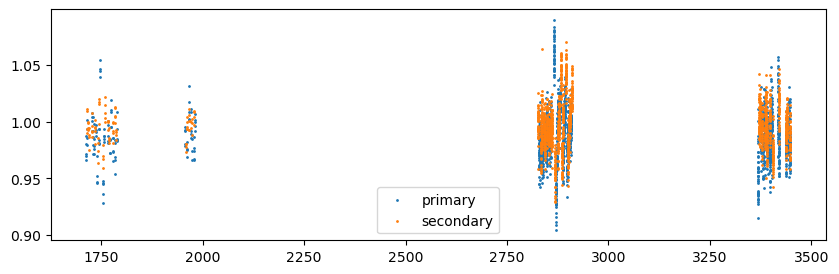

In [52]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1712.66 3.44416 1712.66


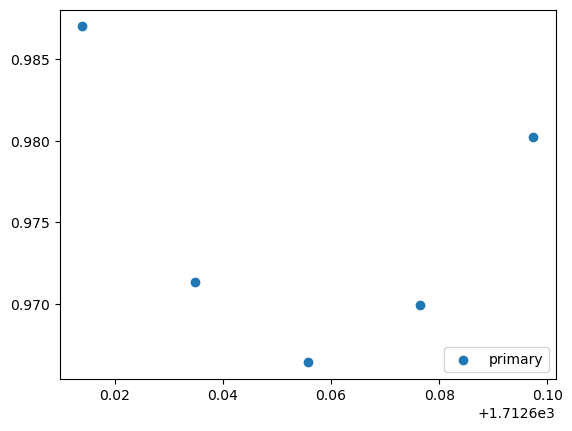

1712.66 3.44416 1716.10416


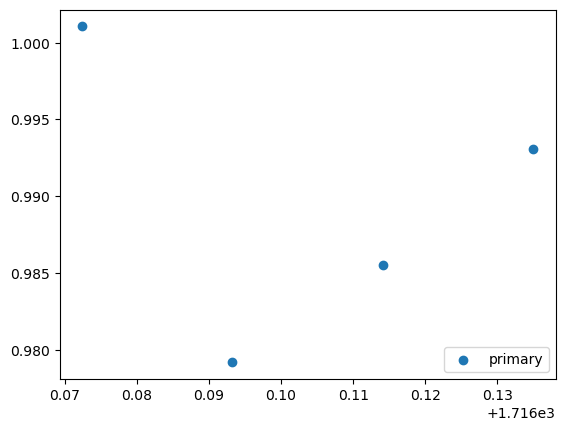

1712.66 3.44416 1719.54832


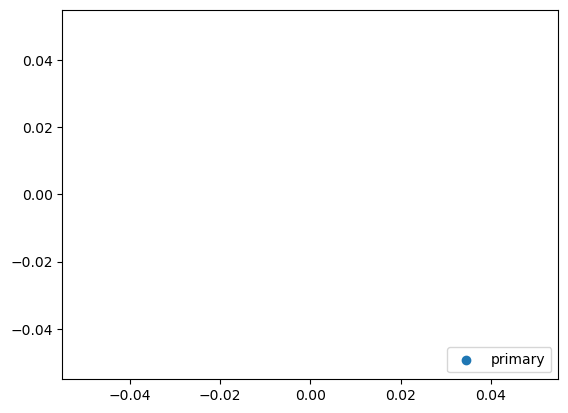

1714.38208 3.44416 1714.38208


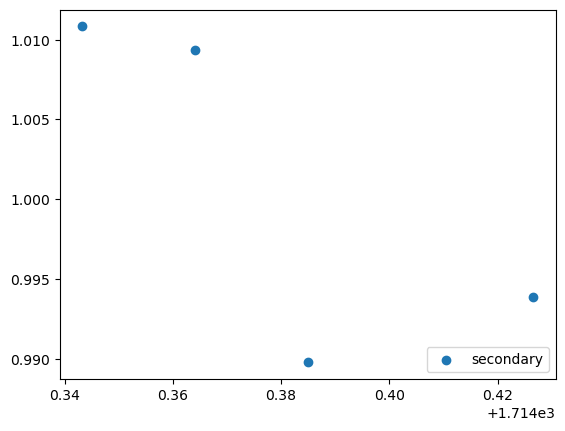

1714.38208 3.44416 1717.82624


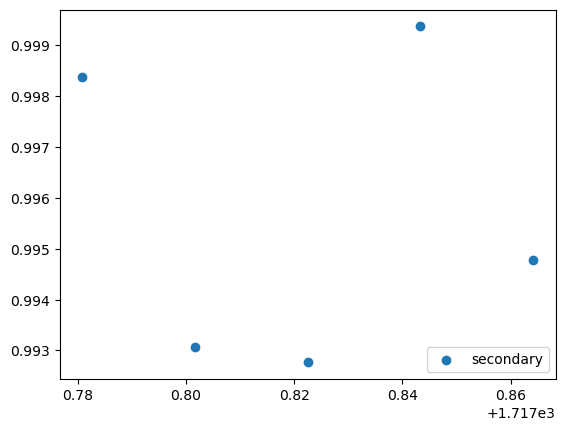

1714.38208 3.44416 1721.2704


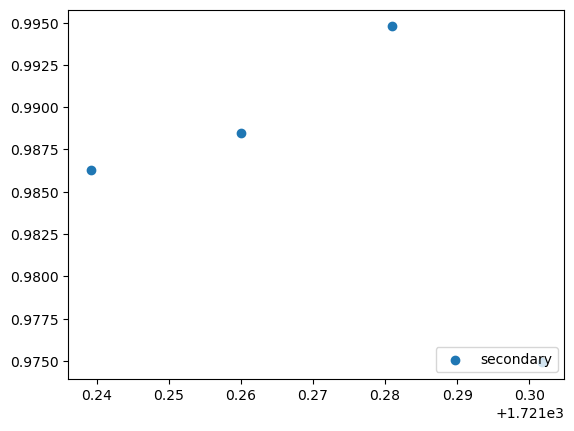

In [53]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in tr_index[0:3]:
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit eclipses in chunks of data

- each chunk is folded with the epoch/peiod, and is then fitted (to increae SNR)

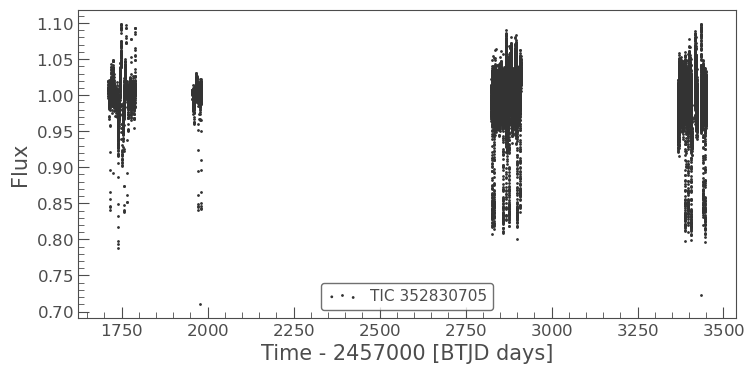

In [58]:
# turn the above data into Lightcurve object

lc_data = lk.LightCurve(time=Time(data.time, format="btjd"), flux=data.flux, flux_err=data.err)
lc_data.meta["LABEL"] = f"TIC {ticid}"
# lc_data.scatter();

Divide the lightcurve into 8 chunks


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 386.70it/s]


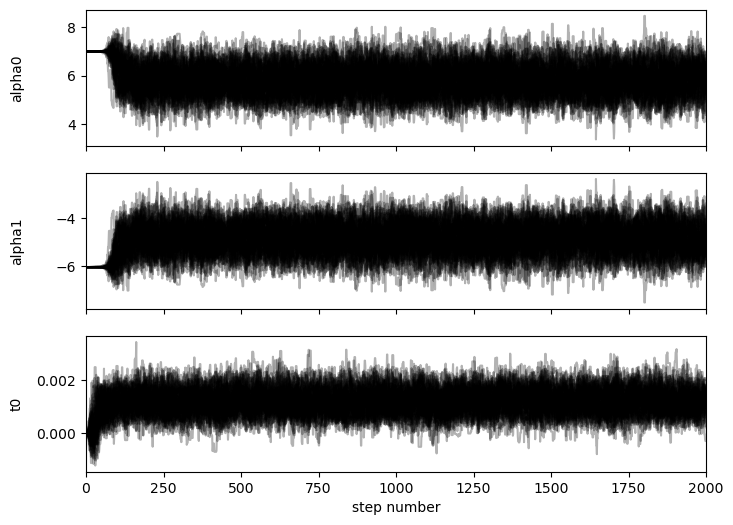

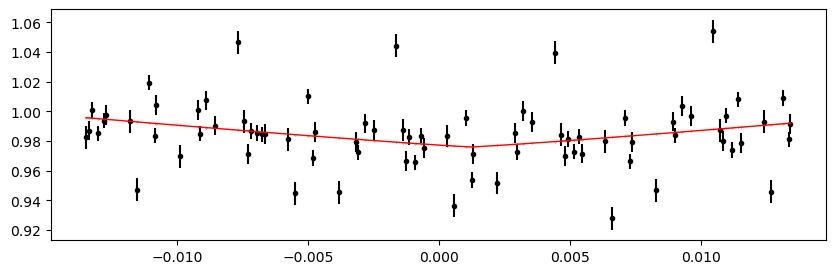

0 1751.5919363489177 5.826774919493266 -4.850728255964098 0.0012255107791319347 0.0004698924037873591 (79)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 418.01it/s]


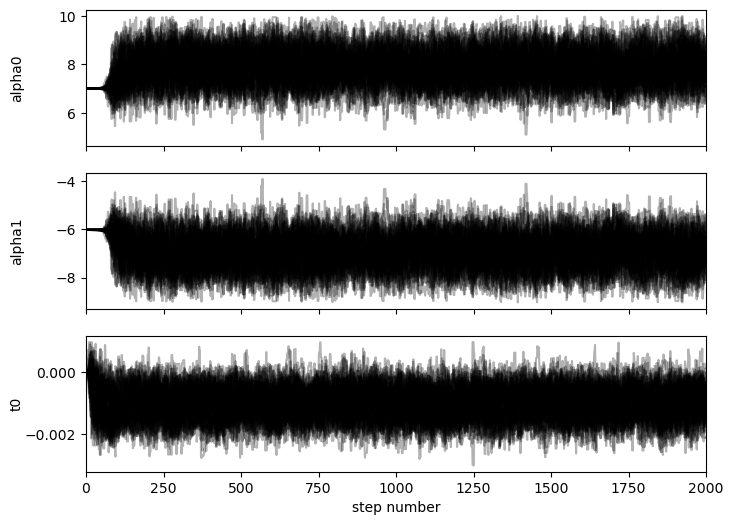

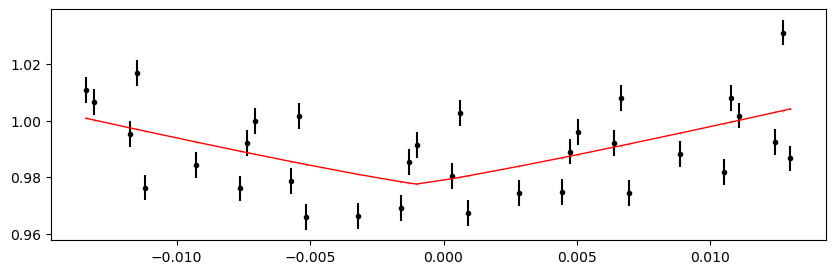

1 1970.1373284468648 7.884295652543026 -6.906764919561747 -0.0009863086392790997 0.0005221075397960117 (33)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 288.28it/s]


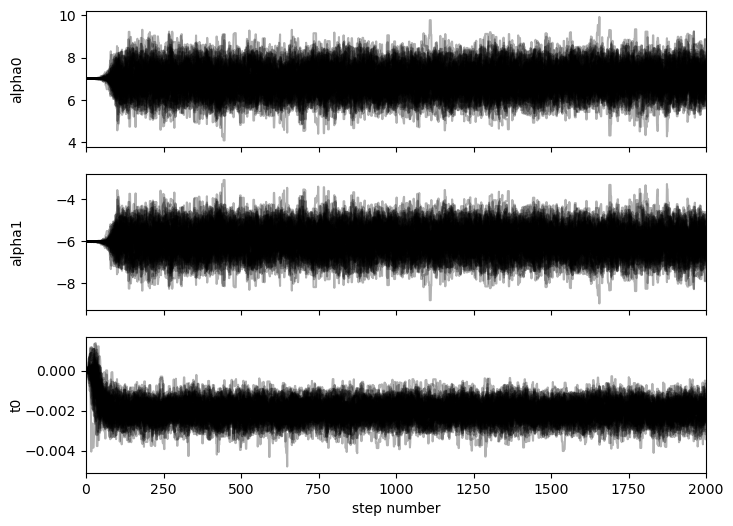

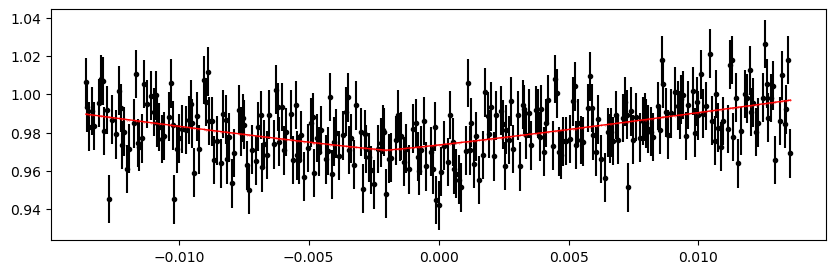

2 2840.3312878602283 6.989826612571721 -6.01901640340564 -0.0020125736502905845 0.00047814154981890407 (284)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 290.18it/s]


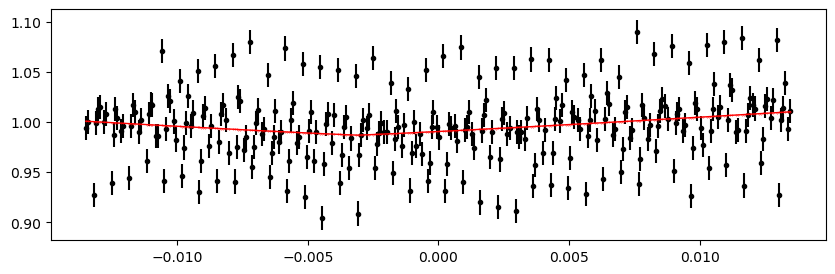

3 2868.870062038542 5.982219659110134 -4.995288415480246 -0.0030941401222499224 0.000601916335485553 (278)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 298.57it/s]


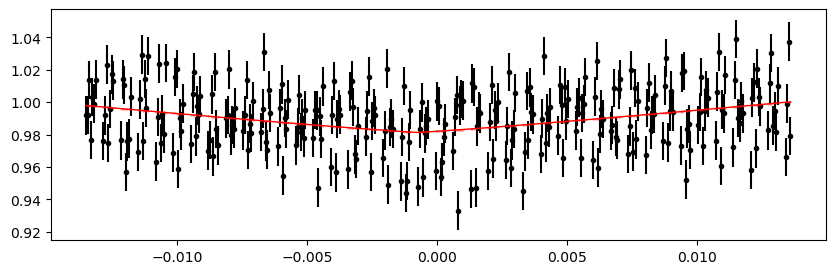

4 2897.3782266201806 5.761585304987397 -4.78027653205476 -0.0007393391467759927 0.0004914647202026072 (284)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 297.08it/s]


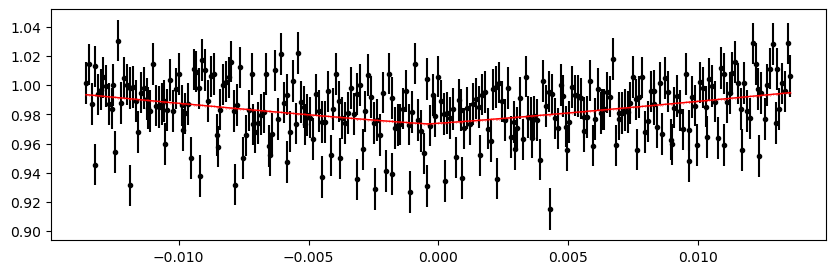

5 3382.590718979146 6.545789017299876 -5.57226854556409 -0.00041385494416839143 0.0005879408505176639 (283)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 336.07it/s]


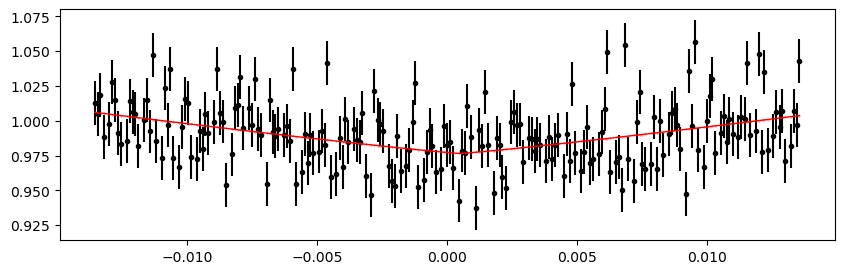

6 3407.8653762687068 8.601406368394372 -7.62490297513582 0.0005008332849288828 0.0005569375914006922 (203)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 336.78it/s]


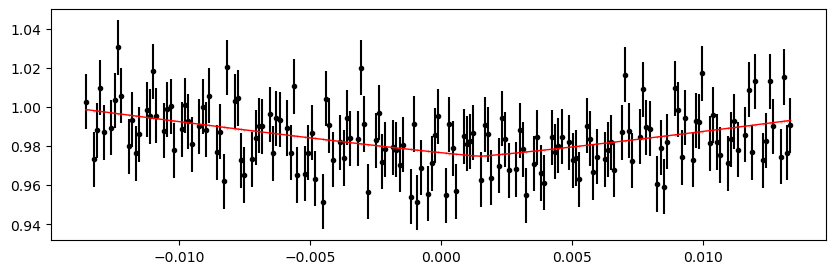

7 3443.3823213473106 6.687997871810277 -5.713215230669208 0.0014845517942013965 0.0008326154983552833 (161)

number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau
0,1751.5919363489177,5.826774919493266,-4.850728255964098,0.0012255107791319347,0.0004698924037873591,1.494662699379815,0.5538180161966535
1,1970.1373284468648,7.884295652543026,-6.906764919561747,-0.0009863086392790997,0.0005221075397960117,1.494662699379815,0.5538180161966535
2,2840.3312878602283,6.989826612571721,-6.01901640340564,-0.0020125736502905845,0.00047814154981890407,1.494662699379815,0.5538180161966535
3,2868.870062038542,5.982219659110134,-4.995288415480246,-0.0030941401222499224,0.000601916335485553,1.494662699379815,0.5538180161966535
4,2897.3782266201806,5.761585304987397,-4.78027653205476,-0.0007393391467759927,0.0004914647202026072,1.494662699379815,0.5538180161966535
5,3382.590718979146,6.545789017299876,-5.57226854556409,-0.00041385494416839143,0.0005879408505176639,1.494662699379815,0.553818016

In [79]:
from types import SimpleNamespace
# reload(etv_functions)

time_breaks = [
    None, 
    # 1739,   # group 3 consecutive long-cadence sectors together
    # 1764, 
    1790, 
    1983,  # use the lone long-cadence sector as-is, no other data in the vicinity
    2853, 
    2882, 
    2911, 
    3395, 
    3424, 
    None, 
]

etv_out_str = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"

print(f"Divide the lightcurve into {len(time_breaks) - 1} chunks")
for i in range(0, len(time_breaks) - 1): # 
    lc = lc_data.truncate(time_breaks[i], time_breaks[i + 1])
    lc_f = lc.fold(epoch_time=t0_primary, period=period, normalize_phase=True)
    lc_f = lc_f.truncate(-window_width_p / 2, window_width_p / 2)
    # ax = lc_f.errorbar(lw=1, markersize=4, marker="o");  ax.set_title(f"Num. data points: {len(lc_f)}"); continue;  # uncomment to just visualize the LC chunks

    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    res = etv_functions.run_mcmc_individual_fit(
        lc_f_data, 
        # use fixed d, Tau, and fit alpha0, alpha1, t0
        [mean_alpha0, mean_alpha1, 0, mean_d, mean_Tau],  # pass 0 as mean_t0, as the LC has been folded with t0 as midpoint
        # nruns=10000, discard=1000,
        nruns=2000, discard=1000,
        # nruns=1000, discard=400,
        # nruns=20, discard=1,
        pool=None, 
        plot_chains=i <= 2,  # the 2 long cadecne chunk, and the first short cadence chunk
        plot=True, 
    )
    _alpha0, _alpha1, _t0, _stdv_t0 = res
    _t = np.mean(lc_f_data.time)  # approximate transit time 
    print(i, _t, *res, f"({len(lc_f_data.time)})")
    etv_out_str += ",".join([str(s) for s in [i, _t, _alpha0, _alpha1, _t0, _stdv_t0, mean_d, mean_Tau]])
    etv_out_str += "\n"
    

print("")
print(etv_out_str)


Divide the lightcurve into 8 chunks


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 402.17it/s]


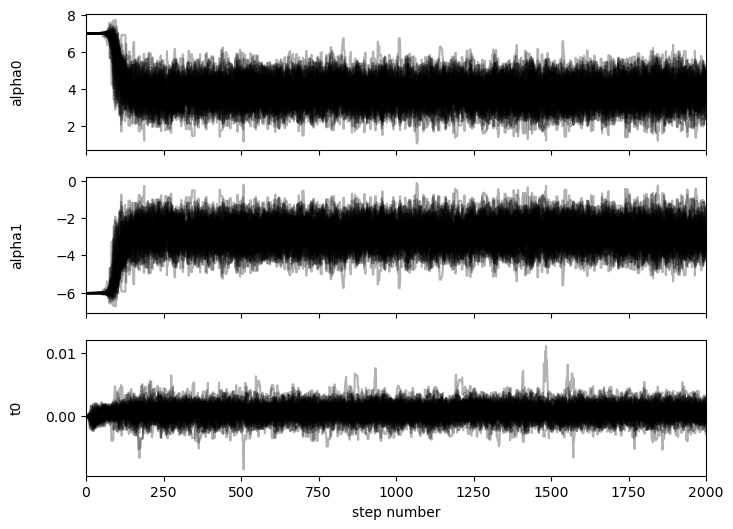

0 1750.6280964158136 3.8517186274205004 -2.8624309308564944 0.0007220589252165568 0.001162850862542509 (63)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 411.47it/s]


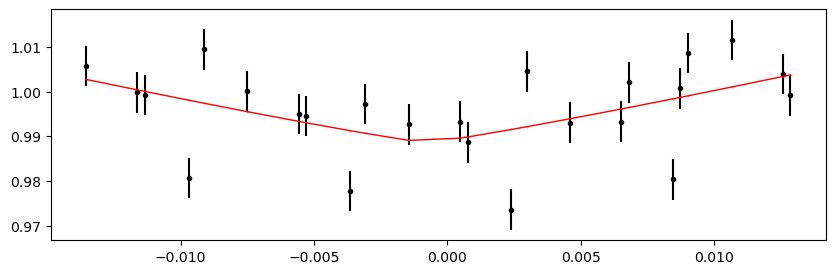

1 1967.815557356207 5.056107646991694 -4.067602989891963 -0.0007542899725289176 0.0009380849105684758 (24)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 307.00it/s]


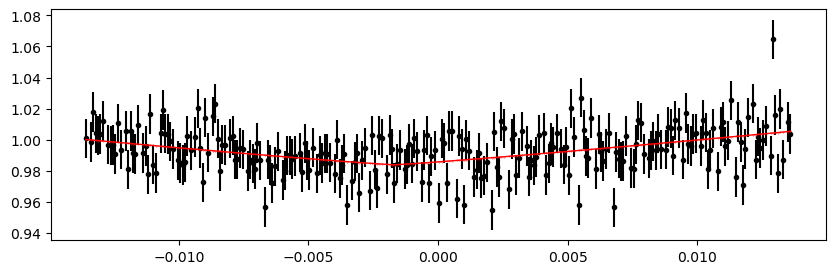

2 2838.255438942188 6.040355568913627 -5.0565279836427175 -0.001698439497919283 0.0006826494810144166 (243)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 295.82it/s]


3 2868.1149667491186 4.357734793281395 -3.3695927272276505 -0.003921676079814204 0.0009008563701455928 (284)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 286.89it/s]


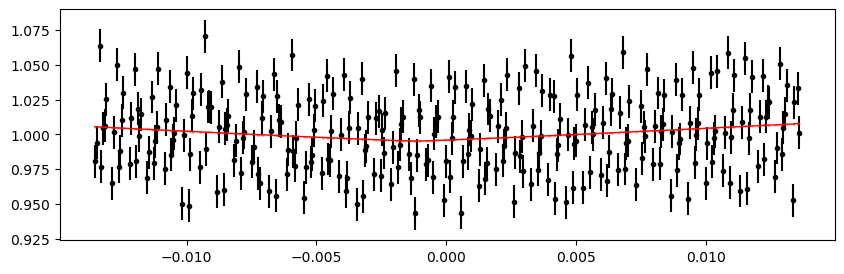

4 2898.138556684175 4.068797142503705 -3.0736089327427507 -0.0011781670844870575 0.0008998632681868146 (283)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 300.34it/s]


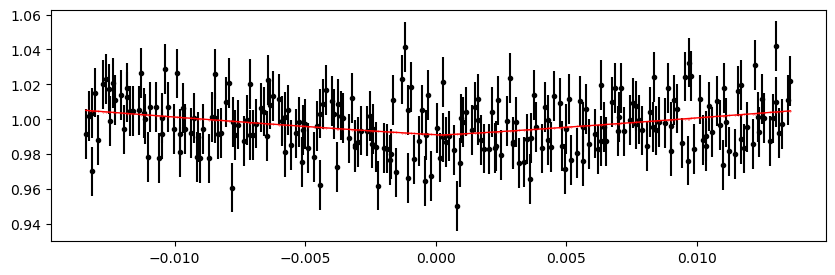

5 3381.3983916631737 4.75957306459064 -3.768604949716389 0.00022685981520407142 0.0009514867957954705 (242)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 371.50it/s]


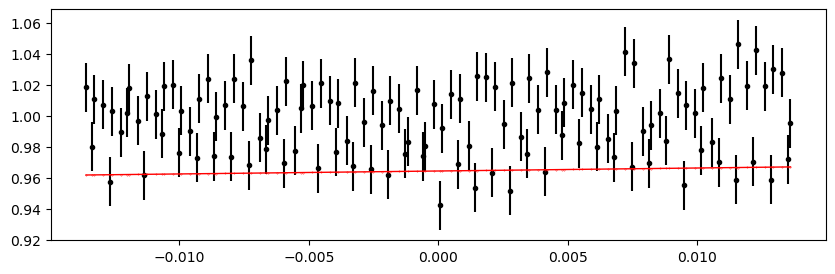

6 3407.760825242217 1.478057568311826 -0.526113565774524 -0.07228349543112561 0.19673241265334643 (123)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 390.10it/s]


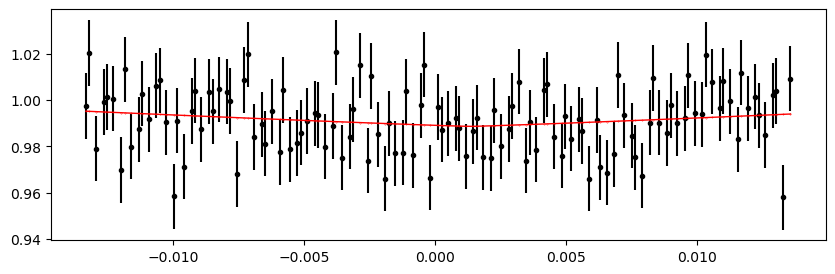

7 3441.0165636571173 2.60357712349237 -1.6149175375455238 0.0013590205316531497 0.1347761992837755 (121)

number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau
0,1750.6280964158136,3.8517186274205004,-2.8624309308564944,0.0007220589252165568,0.001162850862542509,1.494662699379815,0.5538180161966535
1,1967.815557356207,5.056107646991694,-4.067602989891963,-0.0007542899725289176,0.0009380849105684758,1.494662699379815,0.5538180161966535
2,2838.255438942188,6.040355568913627,-5.0565279836427175,-0.001698439497919283,0.0006826494810144166,1.494662699379815,0.5538180161966535
3,2868.1149667491186,4.357734793281395,-3.3695927272276505,-0.003921676079814204,0.0009008563701455928,1.494662699379815,0.5538180161966535
4,2898.138556684175,4.068797142503705,-3.0736089327427507,-0.0011781670844870575,0.0008998632681868146,1.494662699379815,0.5538180161966535
5,3381.3983916631737,4.75957306459064,-3.768604949716389,0.00022685981520407142,0.0009514867957954705,1.494662699379815,0.5538180161

In [81]:
etv_out_str_s = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"

print(f"Divide the lightcurve into {len(time_breaks) - 1} chunks")
for i in range(0, len(time_breaks) - 1): # 
    lc = lc_data.truncate(time_breaks[i], time_breaks[i + 1])
    lc_f = lc.fold(epoch_time=t0_secondary, period=period, normalize_phase=True)
    lc_f = lc_f.truncate(-window_width_s / 2, window_width_s / 2)
    # ax = lc_f.errorbar(lw=1, markersize=4, marker="o");  ax.set_title(f"Num. data points: {len(lc_f)}"); continue;  # uncomment to just visualize the LC chunks

    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    res = etv_functions.run_mcmc_individual_fit(
        lc_f_data, 
        # use fixed d, Tau, and fit alpha0, alpha1, t0
        [mean_alpha0, mean_alpha1, 0, mean_d, mean_Tau],  # pass 0 as mean_t0, as the LC has been folded with t0 as midpoint
        # nruns=10000, discard=1000,
        nruns=2000, discard=1000,
        # nruns=1000, discard=400,
        # nruns=20, discard=1,
        pool=None, 
        plot_chains=i <= 2,  # the 2 long cadecne chunk, and the first short cadence chunk
        plot=True, 
    )
    _alpha0, _alpha1, _t0, _stdv_t0 = res
    _t = np.mean(lc_f_data.time)  # approximate transit time 
    print(i, _t, *res, f"({len(lc_f_data.time)})")
    etv_out_str_s += ",".join([str(s) for s in [i, _t, _alpha0, _alpha1, _t0, _stdv_t0, mean_d, mean_Tau]])
    etv_out_str_s += "\n"
    

print("")
print(etv_out_str_s)


## ETV O-C plot

Note: 0 data points in df_primary filtered out due to huge O-C error.
Note: 2 data points in in_df_secondary filtered out due to huge O-C error.


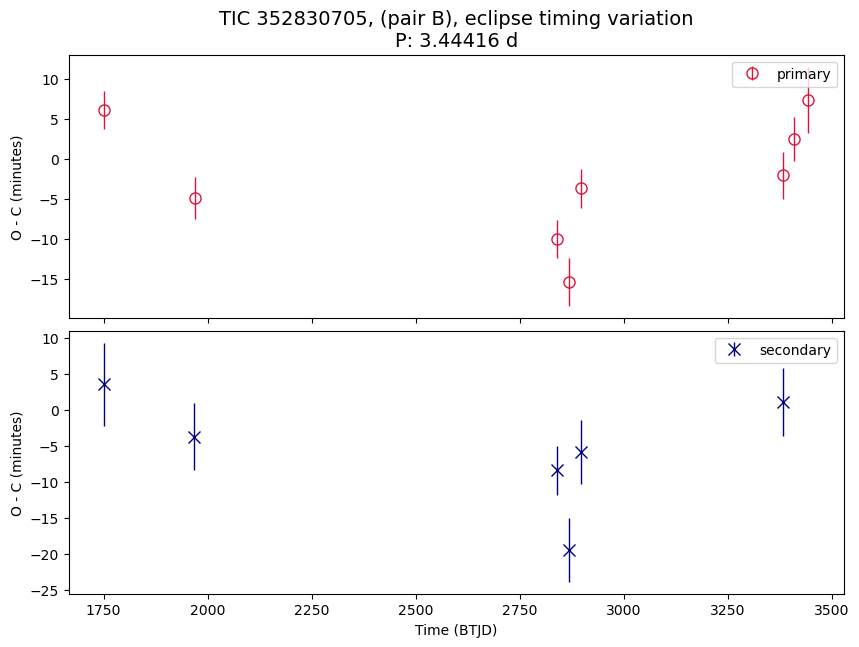

In [90]:
%matplotlib inline
# %matplotlib widget


title_suffix = "(pair B), eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

# in_df_primary = pd.read_csv(outfile_path)
from io import StringIO
in_df_primary = pd.read_csv(StringIO(etv_out_str))
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    # in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary = pd.read_csv(StringIO(etv_out_str_s))
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

In [87]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (30min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

In [ ]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
plt.xlim(0, 2500)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 500)
    plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 100)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [ ]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [ ]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )

    axs = plot_oc_folded(
        period_min=None, period_max=50,
        period_min_s=None, period_max_s=None
    )

    axs = plot_oc_folded(
        period_min=60, period_max=None,
        period_min_s=None, period_max_s=None
    )
    
    # tweak_axs(axs)

## Results Summary

In [89]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "O-C suggests long-linear trend. Very low SNR even after grouping multiple dips together for fitting."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

0
tic                                                                                                     352830705
has_etv                                                                                                        Y?
comments     O-C suggests long-linear trend. Very low SNR even after grouping multiple dips together for fitting.
period                                                                                                    3.44416
depth_pct_p                                                                                                602.81
depth_pct_s                                                                                                582.67
epoch_p                                                                                                   1712.66
epoch_s                                                                                                1714.38208
num_sectors                                                                                                    10
time_span                                                                                                 1738.23
time_start                                                                                                1711.38
time_end                                                                                                  3449.61


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
352830705,Y?,O-C suggests long-linear trend. Very low SNR even after grouping multiple dips together for fitting.,3.44416,602.81,582.67,1712.66,1714.38208,10,1738.23,1711.38,3449.61

